<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Definitions" data-toc-modified-id="Definitions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Definitions</a></span></li><li><span><a href="#BLISS-sxdm-command-syntax" data-toc-modified-id="BLISS-sxdm-command-syntax-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>BLISS sxdm command syntax</a></span></li><li><span><a href="#File-structure" data-toc-modified-id="File-structure-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File structure</a></span></li></ul></li><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Inspect-data" data-toc-modified-id="Inspect-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inspect data</a></span><ul class="toc-item"><li><span><a href="#Conversion-to-orthonormal-reciprocal-space" data-toc-modified-id="Conversion-to-orthonormal-reciprocal-space-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Conversion to orthonormal reciprocal space</a></span></li></ul></li><li><span><a href="#Extract-local-structural-parameters" data-toc-modified-id="Extract-local-structural-parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Extract local structural parameters</a></span></li></ul></div>

# 4D-SXDM tutorial


This notebook introduces basic exploration and preprocessing of 4D-SXDM data obatined on beamline ID01 @ ESRF using the in-house developed library `sxdm`. 

**Requirements**:
* An ESRF single sign-on (SSO)
* Basic knowledge of [Jupyter notebooks](https://jupyter.org/)
* Intermediate knowledge of Python

<div class="alert alert-block alert-warning">
<b>Warning:</b> This notebook deals with SXDM data produced by BLISS, the new control system of ESRF. BLISS is still under development and its structure changes relatively often. Some code in this notebook may therefore be out of date (as well as some info/explanations) and not work correctly. If this is the case, please submit an <a href="https://gitlab.esrf.fr/id01-science/id01-sxdm-utils/-/issues">issue</a>
.
</div>

## Introduction

### Definitions

* _SXDM_: scanning X-ray diffraction microscopy. 
* _4D-SXDM_: A crystal is placed at a Bragg condition so that a Bragg peak is visible on a 2D detector. A nanofocussed beam is then raster scanned across the crystal. At each $(x, y)$ beam position, a detector frame is collected. Thus, a complete 4D-SXDM scan consists of a series of detector frames collected at different nanobeam positions. Namely, one obtains intensity as a function of $(x, y, D_y, D_z)$, where $D_y, D_z$ are the two dimensions of the detector.

4D-SXDM thus refers to SXDM data collected at a single angle, i.e. without rocking the sample. This corresponds to the output of individual `asxdm()` or `dsxdm()` commands run in `BLISS` on ID01.

### BLISS sxdm command syntax 

A detailed description is found [here](https://confluence.esrf.fr/pages/viewpage.action?pageId=96391480). The most basic command, which is executed by all other more complex ones, is the absolute 4D sxdm scan:

```python
asxdm(
    x_fast_mot,  # first piezo motor to be scanned (the fast one)
    x_min,       # first motor minimum coordinate
    x_max,       # first motor maximum coordinate
    x_nb_points, # first motor numer of points
    y_slow_mot,  # second piezo motor to be scanned (the slow one)
    y_min,       # second motor minimum coordinate
    y_max,       # second motor maximum coordinate
    y_nb_points, # second motor numer of points
    expo_time,   # detector exposure time per point (seconds)
):
```

### File structure

During an experiment data is saved on the ESRF NICE cluster. Each experiment has a directory tree dedicated to it. For example, data collected during the the `MAXXXX` experiment would be located in `/data/visitor/MAXXXX/id01/yyyy-mm-dd/`. Here a set of sample data is used to demonstrate how to process 4D-SXDM datasets. Its root directory is:

In [1]:
path_exp = './data/MA1234/id01/20230710'

Examining its contents one sees the folder named `sample`:

In [2]:
!tree -L 1 {path_exp}

./data/MA1234/id01/20230710
├── sample
└── sample_analysis

2 directories, 0 files


The `sample` folder contains all the data and metadata pertaining the sample named `sample`. It was created by using the `ID01newsample` BLISS command. One should thus run this command every time a sample is changed. 

Within `sample`, one finds one or more `sample_xxxx` folders:

In [3]:
!tree -L 1 {path_exp}/sample

./data/MA1234/id01/20230710/sample
└── sample_0001

1 directory, 0 files


Each folder corresponds to a dataset, and was initialised using the `ID01newdataset` command. Again the idea is to isolate conceptually different scans routines from eachother. For example, two datasets may be two sets of SXDM scans performed at different temperatures.

Finally, within each dataset directory there will be a folder for each scan performed,

In [4]:
!tree -L 2 {path_exp}/sample

./data/MA1234/id01/20230710/sample
└── sample_0001
    ├── sample_0001.h5
    ├── scan0001
    ├── scan0002
    ├── scan0003
    ├── scan0004
    └── scan0005

6 directories, 1 file


Everytime one enters one of these subdirectories, an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) (`.h5`) file is present. The HDF5 format allows to store data and metadata together in a single file. Moreover, a given `.h5` file can contain links to another `.h5` file. Thus, even if the "real" data is contained in an `.h5` file somwhere down a directory tree, a "master" `.h5` file can point to it. This is exactly what happens in the present case, where each file in a parent directory contains links to the file in the directory below it. 

Most useful is the file that pertains to a certain dataset,

In [5]:
path_dset = f"{path_exp}/sample/sample_0001/sample_0001.h5"

To quickly inspect its contents one can use a tool developed at the EUXFEL that traverses the file's contents and exposes them as an html (interactive) output:

In [6]:
from h5glance import H5Glance as h5p

h5p(path_dset)

./data/MA1234/id01/20230710/sample/sample_0001/sample_0001.h5/ (9 attributes)
├1.1	(8 children) (2 attributes)
├2.1	(8 children) (2 attributes)
├3.1	(8 children) (2 attributes)
├4.1	(8 children) (2 attributes)
└5.1	(8 children) (2 attributes)

The contents of the file follow the [NeXus](https://www.nexusformat.org/) convention - eventually at any synchrotron in the world the data files will have this same structure. The meaning of the data (techicnally: a `dataset`) contained in each hdf5 "folder" (technically: a `group`) should be easy to understand by exploring the file structure (If not, check the link above for more info). The ESRF software group has developed a [series of tools](http://www.silx.org/doc/silx/latest/Tutorials/io.html) to easily visualise these hierarchical data when sitting at the beamline.

In python, an HDF5 file is easily opened and its data retrieved using [h5py](https://docs.h5py.org/en/stable/quick.html#quick). A safe way to do so without having to remember to close the file afterwards is through the use of a context manager. For example, to read the value of the angle `delta` at which the diffractometer was placed during the measurement:

In [7]:
import h5py

with h5py.File(path_dset) as h5f:
    print(h5f['/1.1/instrument/positioners/delta/'][()])

112.852


Or the shape of the raw data from a 4D-SXDM map:

In [8]:
with h5py.File(path_dset) as h5f:
    print(h5f['/1.1/measurement/mpx1x4/'].shape) # x*y, D_x, D_y

(3600, 516, 516)


However, as it will be shown below, python libraries specific to ID01 have been developed to hide such `h5py` code from the user and retrieve data in a more straightforward way. 

## Import libraries

To begin, the necessary python libraries are imported. Note that [sxdm](https://gitlab.esrf.fr/id01-science/id01-sxdm-utils) and [id01lib](https://gitlab.esrf.fr/id01-science/id01-core) are developed on ID01 and not available on PyPI yet. Follow the [installation](#Installation) steps above to obtain them.

In [9]:
import sxdm
import id01lib

import xrayutilities as xu
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

## Inspect data

<div class="alert alert-block alert-info">
    <b>Note:</b> all of this code can be run <i>live</i> while data is being acquired on the beamline.
</div>

As explained above, our entry point to the data is the path to the dataset HDF5 file. Define it as `path_dset`:

In [10]:
path_dset = f"{path_exp}/sample/sample_0001/sample_0001.h5"

The following commands generates a table of the scans contained within such dataset:

In [11]:
sxdm.io.bliss.get_scan_table(path_dset)

HTML(value='<div>\n<table class="specs rendered_html output_html" style="font-size: small">\n  <tbody>\n    <t…

This file thus contains only `asxdm` commands, i.e. 4D-SXDM maps expressed in absolute piezo coordinates (in microns).
To visually inspect the maps generated by integrating the counts ending up within the ROIs defined on the detector at the time of the experiment, one can use:

In [12]:
viz = sxdm.widgets.bliss.InspectSXDMCounter(path_dset, default_counter="mpx1x4_mpx4int")
viz.show()

This widget also displays any BLISS counter whose value was saved at each `pix,piy` position of the SXDM map. Have a look its docstring to discover the additional keyword arguments that it accepts. The class `InspectSXDMCounter` also exposes a few useful methods; for example, to extract the array corresponding to the image active in the widget:

In [13]:
viz.roidata

array([[ 210.,  179.,  196., ...,  170.,  203.,  153.],
       [ 253.,  198.,  204., ...,  185.,  166.,  192.],
       [ 232.,  168.,  178., ...,  178.,  178.,  168.],
       ...,
       [ 218.,  332.,  298., ...,  327.,  320.,  242.],
       [ 244.,  312.,  433., ...,  373.,  296.,  358.],
       [ 238.,  472., 3017., ...,  234.,  317.,  698.]])

Or to plot a png version of the active image, to e.g. copy it with a right into a doc file:

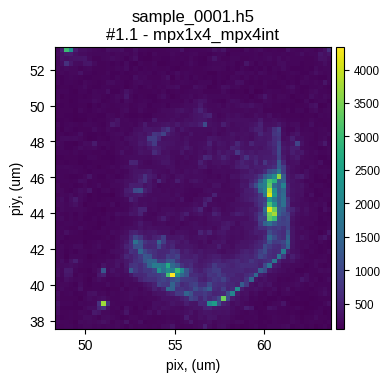

In [14]:
viz.fig

To can visualise the position of the ROIs that were defined during the experiment, one can instead use the `Inspect4DSXDM` widget, which also allows to
* inspect a *detector* space ROI, by ticking the corresponding checkbox and clicking and dragging the cursor on the *detector* space (detector) sum;
* inspect a *sample* space ROI, by ticking the corresponding checkbox and clicking and dragging the cursor on the *sample* space (sample) sum;
* inspect an individual detector frame by clicking anywhere on the sample space (if the sample space checkbox is unticked), changing the position of the red cross. The cross can then be moved with the arrow keys.

In [15]:
scan_no = '1.1'

viz = sxdm.widgets.bliss.Inspect4DSXDM(path_dset, scan_no)
viz.show()

The data selected through the widget can then be retrieved with the appropriate class methods:

Text(0.5, 1.0, 'Sum over sample space ROI')

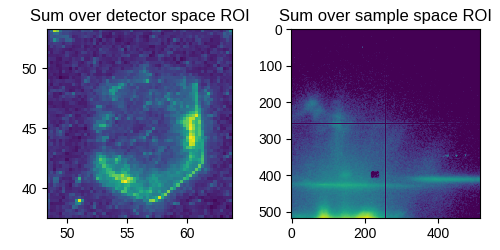

In [16]:
# load sample coordinates and compute extent of the SXDM map
pix, piy = sxdm.io.bliss.get_piezo_motor_positions(path_dset, scan_no)
map_extent = [pix.min(), pix.max(), piy.min(), piy.max()]

# retrieve widget data
dirdata = viz.dir_space_data
recdata = viz.rec_space_data

# plot
fig, ax = plt.subplots(1,2, layout='tight', figsize=(5,2.5))

ax[0].imshow(dirdata, norm=LogNorm(), extent=map_extent, origin='lower')
ax[0].set_title('Sum over detector space ROI')

ax[1].imshow(recdata, norm=LogNorm())
ax[1].set_title('Sum over sample space ROI')

Convenience methods further exist to quickly retrieve the sum over the full direct or reciprocal space of a specific scan:

In [61]:
# sum over direct space
frame_sum = sxdm.io.bliss.get_sxdm_frame_sum(path_dset, scan_no)

# sum over reciprocal space
map_shape = sxdm.io.bliss.get_scan_shape(path_dset, scan_no)

pos_sum = sxdm.io.bliss.get_sxdm_pos_sum(path_dset, scan_no)
pos_sum = pos_sum.reshape(map_shape)

In [62]:
fig, ax = plt.subplots(1,2, layout='tight', figsize=(5,2.5))

ax[0].imshow(frame_sum, norm=LogNorm())
ax[0].set_title('Sum over reciprocal space')

ax[1].imshow(pos_sum, norm=LogNorm(), extent=map_extent, origin='lower')
ax[1].set_title('Sum over direct space')

Note how it was necessary to reshape the `pos_sum` array using the scan shape, 

In [20]:
map_shape

[60, 60]

i.e. the shape of the SXDM map. This is because the raw data is saved as a 3D, and not 4D, array:

In [21]:
with h5py.File(path_dset) as h5f:
    print(h5f['/1.1/measurement/mpx1x4/'].shape) # x*y, D_x, D_y

(3600, 516, 516)


The first dimension corresponds therefore to the flattened scan_shape, while the second and the third are the dimensions of the detector.

### Conversion to orthonormal reciprocal space

It is most often useful to visualise diffraction patterns in reciprocal space, i.e. an orthonormal coordinate system that holds a precise relation with both the sample crystallographic directions as well as the laboratory frame of reference (diffractometer angles and sample stage translations).

<div class="alert alert-block alert-info">
    <b>Note:</b> A comprehensive and very pretty diagram of these coordinate frames and their relations will be uploaded soon.
</div>

The following scan corresponds to the SXDM scan of a 2-25 GaN peak,

In [22]:
scan_no = '3.1'
hkl = 2, -2, 5

Which is found at the following diffractometer angles:

In [23]:
diff_angles = sxdm.utils.calc_refl_id01(
    [2, -2, 5],  # Bragg peak indexes
    "data/GaN.cif",  # CIF file of crystal
    [1, -2, 0],  # crystal direction parallel to lab x at zero angles
    [0, 0, 1],  # crystal direction parallel to lab z at zero angles
    9000,  # X-ray energy
)

print("")
for key, val in diff_angles.items():
    print(f"{key:<5} : {val:}")

XU.materials: Warning: element N used instead of N3-

eta   : 93.0338
phi   : 30.0
nu    : 0.0
delta : 112.2314


To make sure that the right linear transformation from angular to reciprocal space is performed, one must thus subtract from the measured angles any offset that might have been introduced by sample or diffractometer misalignments. This is done by loading the measured angles and then appropriately defining an `offsets` dictionary:

In [24]:
eta, phi, delta = [
    sxdm.io.bliss.get_positioner(path_dset, scan_no, a)
    for a in "eta,phi,delta".split(",")
]

offsets = {
    "eta": eta - diff_angles['eta'],
    "phi": phi + diff_angles['phi'],
    "delta": delta - diff_angles['delta']
}

for key, val in offsets.items():
    print(f"{key:<5} : {val:>6.3f}")

eta   :  0.288
phi   : -6.135
delta :  0.621


Finally, the function `get_qspace_vals` can be used to compute the $q_x, q_y, q_z$ coordinates of each detector pixel at the angles stored in `path_dset` at `scan_no`, taking `offsets` into account:

In [25]:
qx, qy, qz = id01lib.xrd.qspace.bliss.get_qspace_vals(
    path_dset,
    scan_no,
    offsets=offsets,
    ignore_mpx_motors=True,
)

Using cen_pix: row/y=256.169, col/x=138.845
Using det_dist = 0.94004 m
Using energy = 8.99971 keV
NOT correcting the central pixel for mpxy=-14.0, mpxz=0.0
------------------
Subtracting 0.288 from eta
Subtracting -6.135 from phi
Subtracting 0.621 from delta


Now the frame sum for `scan_no` is loaded:

In [26]:
frame_sum = sxdm.io.bliss.get_sxdm_frame_sum(path_dset, scan_no)

0it [00:00, ?it/s]

And displayed in the reciprocal space coordinate frame:

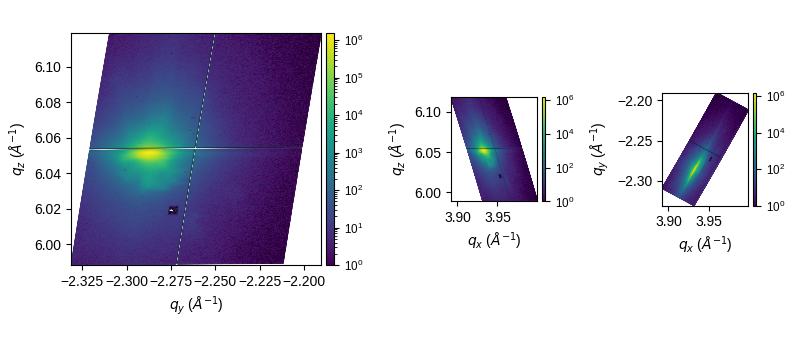

In [27]:
fig, ax = plt.subplots(
    1, 3, figsize=(8, 3.5), dpi=100, gridspec_kw=dict(width_ratios=[2.8, 1, 1])
)

ax[0].pcolormesh(qy, qz, frame_sum, norm=LogNorm(), shading="gouraud")
ax[1].pcolormesh(qx, qz, frame_sum, norm=LogNorm(), shading="gouraud")
ax[2].pcolormesh(qx, qy, frame_sum, norm=LogNorm(), shading="gouraud")

[ax[i].set_ylabel(r"$q_z$ ($\AA^{-1}$)") for i in (0, 1)]
[ax[i].set_xlabel(r"$q_x$ ($\AA^{-1}$)") for i in (1, 2)]

ax[0].set_xlabel(r"$q_y$ ($\AA^{-1}$)")
ax[2].set_ylabel(r"$q_y$ ($\AA^{-1}$)")

for a in ax:
    a.set_aspect("equal")
    sxdm.plot.add_colorbar(a, a.get_children()[0])

fig.tight_layout()

The following 3D plot may aid understanding of how such reciprocal space "slice" is positioned in 3D space:

Text(0.5, 0, '$q_z~(\\AA^{-1})$')

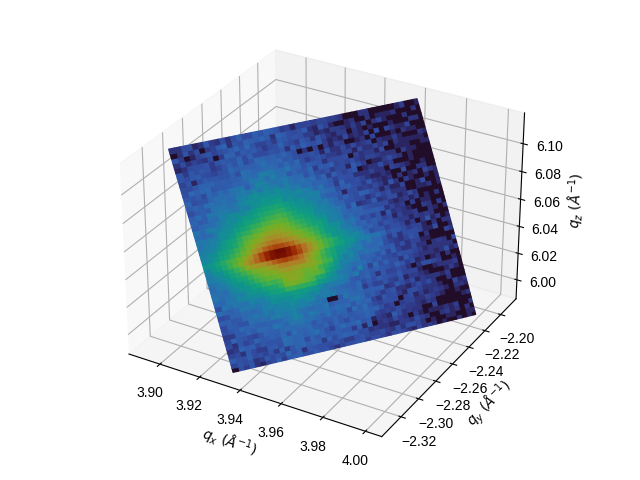

In [28]:
color_map = plt.get_cmap('turbo')

fframe_sum = frame_sum.astype(np.float64)
fframe_sum = np.log(fframe_sum)
fframe_sum /= fframe_sum.max()

I = color_map(fframe_sum)

fig = plt.figure(layout='tight')
ax = fig.add_subplot(projection='3d')

ax.plot_surface(qx, qy, qz, facecolors=I)

ax.set_xlabel(r'$q_x~(\AA^{-1})$')
ax.set_ylabel(r'$q_y~(\AA^{-1})$')
ax.set_zlabel(r'$q_z~(\AA^{-1})$')

## Extract local structural parameters

In [29]:
# reset matplotlib figures
%matplotlib widget

Compute the centre of mass of the peak at each position in the map and separate it in the components along $q_x, q_y, q_z$:

In [30]:
coms = sxdm.process.math.calc_coms_qspace2d(
    path_dset, scan_no, qx, qy, qz
)  # a mask can be supplied!

cx, cy, cz = coms.reshape(*map_shape, 3).transpose(2, 0, 1)

  0%|          | 0/8 [00:00<?, ?it/s]

Note that these correspond to the coordinates of the scattering vector $q_{local}$ pointing to the 2-25 peak at each position of the map. Each array thus has the shape of the SXDM map:

In [31]:
print(cx.shape, cy.shape, cz.shape)

(60, 60) (60, 60) (60, 60)


The coordinates of $q_{local}$ can therefore be plotted like so,

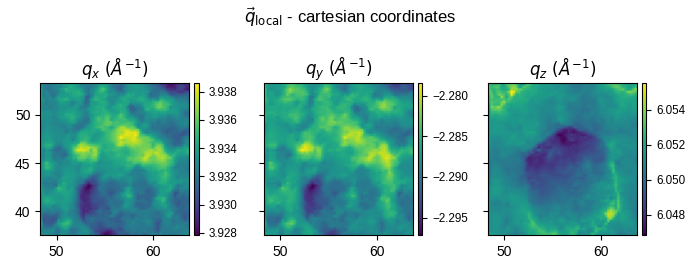

In [32]:
titles = ['$q_x~(\AA^{-1})$', '$q_y~(\AA^{-1})$', '$q_z~(\AA^{-1})$']

fig, ax = plt.subplots(1,3, layout='tight', sharey=True, figsize=(7,2.8))
fig.suptitle(r"$\vec{q}_{\mathrm{local}}$ - cartesian coordinates")

for i, t, c in zip(range(3), titles, [cx, cy, cz]):
    im = ax[i].imshow(c, extent=map_extent, origin='lower')
    cbar = sxdm.plot.add_colorbar(ax[i], im)
    
    ax[i].set_title(t)    

Or converted to [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system) and plotted again:

In [33]:
q = np.sqrt(cx ** 2 + cy ** 2 + cz ** 2)  # distance from origin
inc = np.degrees(np.arccos(cz / q))  # inclination away from qz (vertical) axis
azi = np.degrees(np.arccos(cy / np.sqrt(cx ** 2 + cy ** 2)))  # angle away from qy axis

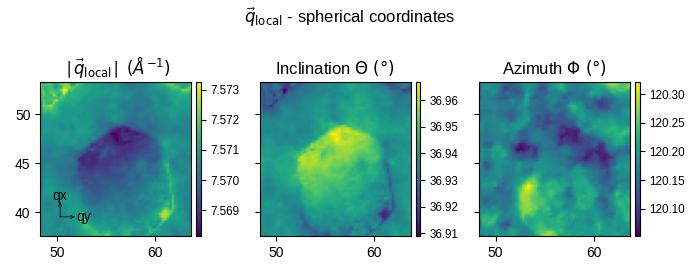

In [34]:
titles = [
    r"$\mid\!\vec{q}_{\mathrm{local}}\!\mid\,(\AA^{-1})$",
    "Inclination $\Theta~(\degree)$",
    "Azimuth $\Phi~(\degree)$",
]

fig, ax = plt.subplots(1, 3, layout="tight", sharey=True, figsize=(7, 2.8))
fig.suptitle(r"$\vec{q}_{\mathrm{local}}$ - spherical coordinates")

for i, t, c in zip(range(len(ax)), titles, [q, inc, azi]):
    im = ax[i].imshow(c, extent=map_extent, origin="lower")
    cbar = sxdm.plot.add_colorbar(ax[i], im)

    ax[i].set_title(t)
    
sxdm.plot.add_directions(ax[0], 'qy', 'qx', 'lower left')

To understand the extent and direction of the movement of $q_{local}$ away from its average position, it is useful to overlay the position of its coordinates on top of the frame sum expressed in reciprocal space:

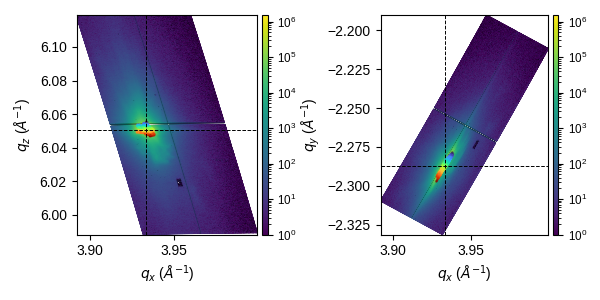

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].pcolormesh(qx, qz, frame_sum, norm=LogNorm(), shading="gouraud")
ax[1].pcolormesh(qx, qy, frame_sum, norm=LogNorm(), shading="gouraud")

ax[0].scatter(cx, cz, c=inc, s=0.5, cmap="turbo", alpha=0.5)
ax[1].scatter(cx, cy, c=azi, s=0.5, cmap="turbo", alpha=0.5)

for a, c0, c1 in zip(ax, [cx.mean(), cx.mean()], [cz.mean(), cy.mean()]):
    a.axvline(c0, lw=0.7, c="k", ls="--")
    a.axhline(c1, lw=0.7, c="k", ls="--")

[ax[i].set_xlabel(r"$q_x$ ($\AA^{-1}$)") for i in (0, 1)]

ax[0].set_ylabel(r"$q_z$ ($\AA^{-1}$)")
ax[1].set_ylabel(r"$q_y$ ($\AA^{-1}$)")

for a in ax:
    a.set_aspect("equal")
    sxdm.plot.add_colorbar(a, a.get_children()[0])

fig.tight_layout()

In addition, it may be useful to repeat the computations in spherical coordinates but relative to an arbitrary reference reciprocal space direction $\vec{q}_0$ (as opposed to the $q_z$ axis), specified by components `cx0`, `cy0`, `cz0`:

In [36]:
# q_local 2D vector field and magnitude
Q = np.array([cx, cy, cz]).reshape(3, np.prod(cx.shape))
q = np.sqrt(cx ** 2 + cy ** 2 + cz ** 2)

# q_0 components
cx0, cy0, cz0 = cx.mean(), cy.mean(), cz.mean()

# q_0 vector and magnitude
Q_av = np.array([cx0, cy0, cz0])
q_av = np.sqrt(cx0 ** 2 + cy0 ** 2 + cz0 ** 2)

# relative inclination and azimuth between the q_local and q_0
inc_rel = np.degrees(np.arccos(np.dot(Q_av, Q).reshape(q.shape) / (q * q_av)))
azi_rel = np.degrees(np.arctan2(cx - cx0, cy - cy0))

Plot:

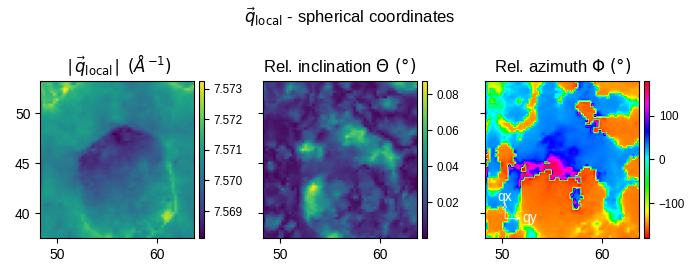

In [37]:
titles = [
    r"$\mid\!\vec{q}_{\mathrm{local}}\!\mid\,(\AA^{-1})$",
    "Rel. inclination $\Theta~(\degree)$",
    "Rel. azimuth $\Phi~(\degree)$",
]

fig, ax = plt.subplots(1, 3, layout="tight", sharey=True, figsize=(7, 2.8))
fig.suptitle(r"$\vec{q}_{\mathrm{local}}$ - spherical coordinates")

for i, t, c in zip(range(len(ax)), titles, [q, inc_rel, azi_rel]):
    im = ax[i].imshow(c, extent=map_extent, origin="lower")
    cbar = sxdm.plot.add_colorbar(ax[i], im)

    ax[i].set_title(t)
    
    if i == 2:
        im.set_cmap('hsv')
        
sxdm.plot.add_directions(ax[2], 'qy', 'qx', 'lower left', color='w')

Visualise the distribution of such centres of mass on the diffraction pattern:

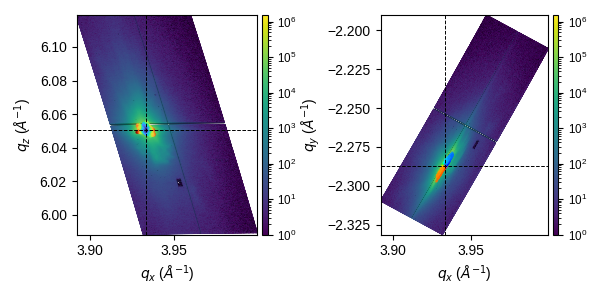

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].pcolormesh(qx, qz, frame_sum, norm=LogNorm(), shading="gouraud")
ax[1].pcolormesh(qx, qy, frame_sum, norm=LogNorm(), shading="gouraud")

ax[0].scatter(cx, cz, c=inc_rel, s=1, cmap="turbo", alpha=0.5)
ax[1].scatter(cx, cy, c=azi_rel, s=0.5, cmap="hsv", alpha=0.5)

for a, c0, c1 in zip(ax, [cx.mean(), cx.mean()], [cz.mean(), cy.mean()]):
    a.axvline(c0, lw=0.7, c="k", ls="--")
    a.axhline(c1, lw=0.7, c="k", ls="--")

[ax[i].set_xlabel(r"$q_x$ ($\AA^{-1}$)") for i in (0, 1)]

ax[0].set_ylabel(r"$q_z$ ($\AA^{-1}$)")
ax[1].set_ylabel(r"$q_y$ ($\AA^{-1}$)")

for a in ax:
    a.set_aspect("equal")
    sxdm.plot.add_colorbar(a, a.get_children()[0])

fig.tight_layout()

Alternative plotting:

In [40]:
strain = (q - q.mean()) / q.mean()
tilt = sxdm.plot.make_hsv(inc_rel, 180 + azi_rel)

fig, ax = plt.subplots(
    1, 2, layout="tight", sharey=True, gridspec_kw={"width_ratios": [1, 1.15]}, figsize=(6,3)
)

ax[0].imshow(strain, extent=map_extent, origin='lower', cmap='RdBu_r', clim=[-5e-4, 5e-4])
ax[1].imshow(tilt, extent=map_extent, origin='lower')

cbar = sxdm.plot.add_colorbar(ax[0], ax[0].get_images()[0])
cbar.ax.ticklabel_format(style='scientific', scilimits=(0,0), useMathText=True)

labels = "+qy,+qx,-qy,-qx,+qy".split(",")

sxdm.plot.add_hsv_colorbar(inc_rel, ax[1], labels, magnitude_precision=2)
sxdm.plot.add_directions(ax[1], 'qy', 'qx', 'lower left', color='k')

ax[0].set_title('Strain along $q_{\mathsf{local}}$', pad=25)
ax[1].set_title('Tilt of $q_{\mathsf{local}}$ relative to $q_{0}$', pad=25)